In [1]:
import os
import os.path as osp
import sys
sys.path.append('/home/wangxiao13/annotation/ilearnmm')
import json
import pickle
from tqdm import tqdm

import numpy as np
from scipy.special import kl_div
import pandas as pd
import matplotlib.pyplot as plt

from multimodal.core.evaluation import mmit_mean_average_precision, top_k_recall, top_k_precision, mean_average_precision

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [3]:
root_path = '/home/wangxiao13/annotation'
test_label_path = osp.join(root_path, 'data/hetu/hetu_text_test_list.txt')
label_map_path =  osp.join(root_path, 'data/hetu/label_map_hetu.txt')
vision_result_path = osp.join(root_path, 'mmaction2/work_dirs/timesformer_video_divST_8x32x1_15e_hetu_rgb/test_results.json')
language_result_path = osp.join(root_path, 'ilearntext2/work_dirs/bert_hetu/test_results.json')
multimodal_result_path = osp.join(root_path, 'ilearnmm/work_dirs/enc_fc_reactor_add_5e_hetu_rgb_text/test_results.json')

# load labels

In [4]:
idx2cat = {}
cat2idx = {}
with open(label_map_path, 'r') as F:
    lines = F.readlines()
for line in lines:
    cat = line.strip()
    idx = len(idx2cat)
    idx2cat[idx] = cat
    cat2idx[cat] = idx
# No dupliacted category name
assert len(idx2cat) == len(cat2idx) 

# Load annotation

In [50]:
pd_pids = []
pd_sents = []
pd_labels = []
gt_cat_idxs = []

with open(test_label_path, 'r') as F:
    lines = F.readlines()

gt_labels = []
for line in lines:
    pid, sent, *labels_idx = line.strip().split('\t')
    pid = int(pid)
    pd_pids.append(pid)
    pd_sents.append(sent)
    labels_idx = [int(idx) for idx in labels_idx]
    gt_cat_idxs.append(labels_idx)
    labels_name = [idx2cat[idx] for idx in labels_idx]
    pd_labels.append(labels_name)
    label = np.zeros(len(idx2cat))
    for idx in labels_idx:
        label[idx] = 1
    gt_labels.append(label)
gt_labels = np.array(gt_labels)

# Load results

In [7]:
def calculate_f1(result, gt_cat_idxs, topk=3):
    assert len(result) == len(gt_cat_idxs)
    precisions = []
    recalls = []
    f1s = []
    for res, gt_idxs in tqdm(zip(result, gt_cat_idxs)):
        gt_idxs = set(gt_idxs)
        #topk = len(gt_idxs)
        topk_idxs = set(np.argsort(res)[-topk:])
        union_idxs = gt_idxs.intersection(topk_idxs)
        precision = len(union_idxs) / topk
        recall = len(union_idxs) / len(gt_idxs)
        if recall == 0 and precision == 0:
            f1 = 0
        else:
            f1 = recall * precision / (recall + precision)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
    return precisions, recalls, f1s

In [8]:
with open(vision_result_path, 'r') as F:
    vision_result = json.load(F)
vision_result = np.array(vision_result)
if len(np.where(vision_result<0)[0]) or len(np.where(vision_result>1)[0]):
    # got logits
    vision_result = sigmoid(vision_result)

In [9]:
with open(language_result_path, 'r') as F:
    language_result = json.load(F)
language_result = np.array(language_result)
if len(np.where(language_result<0)[0]) or len(np.where(language_result>1)[0]):
    # got logits
    language_result = sigmoid(language_result)

In [10]:
with open(multimodal_result_path, 'r') as F:
    multimodal_result = json.load(F)
multimodal_result = np.array(multimodal_result)
if len(np.where(multimodal_result<0)[0]) or len(np.where(multimodal_result>1)[0]):
    # got logits
    multimodal_result = sigmoid(multimodal_result)

In [11]:
ideal_mm_result = []
for idx in range(len(vision_result)):
    vision_res = vision_result[idx]
    language_res = language_result[idx]
    cat_idxs = gt_cat_idxs[idx]
    ideal_mm_res = np.minimum(vision_res, language_res)
    for idx in cat_idxs:
        score = max(vision_res[idx], language_res[idx])
        ideal_mm_res[idx] = score
    ideal_mm_result.append(ideal_mm_res)

In [12]:
mean_mm_result = []
for idx in range(len(vision_result)):
    vision_res = vision_result[idx]
    language_res = language_result[idx]
    cat_idxs = gt_cat_idxs[idx]
    mean_mm_res = (vision_res + language_res)/2
    mean_mm_result.append(mean_mm_res)

# Label based analysis

In [13]:
mAP_label = mmit_mean_average_precision(vision_result, gt_labels)
mAP_sampple = mean_average_precision(vision_result, gt_labels)
precision = top_k_precision(vision_result, gt_labels, topk=(1,2,3))
recall = top_k_recall(vision_result, gt_labels, topk=(2,3,4))
print('Vision model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

/home/wangxiao13/annotation/ilearnmm/multimodal/core/evaluation/accuracy.py:272: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
Vision model:
mAP_label: 0.76
mAP_sample: 0.45
Precision@1 0.70, Precision@2 0.63, Precision@3 0.50
Recall@2 0.66, Recall@3 0.77, Recall@4 0.82


In [14]:
mAP_label = mmit_mean_average_precision(language_result, gt_labels)
mAP_sampple = mean_average_precision(language_result, gt_labels)
precision = top_k_precision(language_result, gt_labels, topk=(1,2,3))
recall = top_k_recall(language_result, gt_labels, topk=(2,3,4))
print('Language model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

Language model:
mAP_label: 0.60
mAP_sample: 0.23
Precision@1 0.55, Precision@2 0.48, Precision@3 0.38
Recall@2 0.51, Recall@3 0.59, Recall@4 0.65


In [15]:
mAP_label = mmit_mean_average_precision(multimodal_result, gt_labels)
mAP_sampple = mean_average_precision(multimodal_result, gt_labels)
precision = top_k_precision(multimodal_result, gt_labels, topk=(1,2,3))
recall = top_k_recall(multimodal_result, gt_labels, topk=(2,3,4))
print('Multimodal model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

Multimodal model:
mAP_label: 0.80
mAP_sample: 0.53
Precision@1 0.75, Precision@2 0.67, Precision@3 0.53
Recall@2 0.70, Recall@3 0.81, Recall@4 0.86


In [16]:
mAP_label = mmit_mean_average_precision(mean_mm_result, gt_labels)
mAP_sampple = mean_average_precision(mean_mm_result, gt_labels)
precision = top_k_precision(mean_mm_result, gt_labels, topk=(1,2,3))
recall = top_k_recall(mean_mm_result, gt_labels, topk=(2,3,4))
print('Mean multimodal model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

Mean multimodal model:
mAP_label: 0.76
mAP_sample: 0.46
Precision@1 0.74, Precision@2 0.63, Precision@3 0.49
Recall@2 0.67, Recall@3 0.76, Recall@4 0.81


In [17]:
mAP_label = mmit_mean_average_precision(ideal_mm_result, gt_labels)
mAP_sampple = mean_average_precision(ideal_mm_result, gt_labels)
precision = top_k_precision(ideal_mm_result, gt_labels, topk=(1,2,3))
recall = top_k_recall(ideal_mm_result, gt_labels, topk=(2,3,4))
print('Ideal multimodal model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

Ideal multimodal model:
mAP_label: 0.91
mAP_sample: 0.80
Precision@1 0.89, Precision@2 0.79, Precision@3 0.60
Recall@2 0.83, Recall@3 0.93, Recall@4 0.95


In [18]:
mAP_label = mmit_mean_average_precision(gt_labels, gt_labels)
mAP_sampple = mean_average_precision(gt_labels, gt_labels)
precision = top_k_precision(gt_labels, gt_labels, topk=(1,2,3))
recall = top_k_recall(gt_labels, gt_labels, topk=(2,3,4))
print('God model:')
print('mAP_label: %.2f' % mAP_label)
print('mAP_sample: %.2f' % mAP_sampple)
print('Precision@1 %.2f, Precision@2 %.2f, Precision@3 %.2f' % (precision[0], precision[1], precision[2]))
print('Recall@2 %.2f, Recall@3 %.2f, Recall@4 %.2f' % (recall[0], recall[1], recall[2]))

God model:
mAP_label: 1.00
mAP_sample: 1.00
Precision@1 1.00, Precision@2 0.89, Precision@3 0.64
Recall@2 0.95, Recall@3 1.00, Recall@4 1.00


# Sampled based analysis

In [19]:
topk = 3

In [20]:
pd_vision_precision, pd_vision_recall, pd_vision_f1 = calculate_f1(vision_result, gt_cat_idxs, topk)

41054it [00:00, 55499.75it/s]


In [21]:
pd_language_precision, pd_language_recall, pd_language_f1 = calculate_f1(language_result, gt_cat_idxs, topk)

41054it [00:00, 58448.54it/s]


In [22]:
pd_multimodal_precision, pd_multimodal_recall, pd_multimodal_f1 = calculate_f1(multimodal_result, gt_cat_idxs, topk)

41054it [00:00, 55744.76it/s]


In [54]:
improved = set()
damaged = set()
compromised = set()
equal = set()
for idx, pid in enumerate(pd_pids):
    min_f1 = min(pd_vision_f1[idx], pd_language_f1[idx])
    max_f1 = max(pd_vision_f1[idx], pd_language_f1[idx])
    mm_f1 = pd_multimodal_f1[idx]
    if min_f1 != max_f1:
        if mm_f1 > max_f1:
            improved.add(idx)
        elif mm_f1 < min_f1:
            damaged.add(idx)
        else:
            compromised.add(idx)
    else:
        if mm_f1 > max_f1:
            improved.add(idx)
        elif mm_f1 < max_f1:
            damaged.add(idx)
        else:
            equal.add(idx)
print('Multimodal Fusion reletive to best of vision-language model:')
print('%.2f%% of samples are improved.' % (len(improved)/len(pd_pids)*100))
print('%.2f%% of samples are damaged.' % (len(damaged)/len(pd_pids)*100))
print('%.2f%% of samples are compromised.' % (len(compromised)/len(pd_pids)*100))
print('%.2f%% of samples are equal.' % (len(equal)/len(pd_pids)*100))

Multimodal Fusion reletive to best of vision-language model:
3.76% of samples are improved.
0.58% of samples are damaged.
43.45% of samples are compromised.
52.20% of samples are equal.


In [58]:
improved_pids = [pd_pids[idx] for idx in improved]
improved_pids[10:20]

[40729247416,
 34125685754,
 37900389482,
 41405383679,
 31994450960,
 40076774090,
 33506732384,
 44211648839,
 34377839800,
 48230657686]

In [24]:
improved = set()
damaged = set()
equal = set()
for idx, pid in enumerate(pd_pids):
    single_f1 = pd_vision_f1[idx]
    mm_f1 = pd_multimodal_f1[idx]

    if mm_f1 > single_f1:
        improved.add(idx)
    elif mm_f1 < single_f1:
        damaged.add(idx)
    else:
        equal.add(idx)
print('Multimodal Fusion reletive to vision model:')
print('%.2f%% of samples are improved.' % (len(improved)/len(pd_pids)*100))
print('%.2f%% of samples are damaged.' % (len(damaged)/len(pd_pids)*100))
print('%.2f%% of samples are equal.' % (len(equal)/len(pd_pids)*100))

Multimodal Fusion reletive to vision model:
11.89% of samples are improved.
6.06% of samples are damaged.
82.05% of samples are equal.


In [27]:
improved = set()
damaged = set()
equal = set()
for idx, pid in enumerate(pd_pids):
    single_f1 = pd_language_f1[idx]
    mm_f1 = pd_multimodal_f1[idx]

    if mm_f1 > single_f1:
        improved.add(idx)
    elif mm_f1 < single_f1:
        damaged.add(idx)
    else:
        equal.add(idx)
print('Multimodal Fusion reletive to language model:')
print('%.2f%% of samples are improved.' % (len(improved)/len(pd_pids)*100))
print('%.2f%% of samples are damaged.' % (len(damaged)/len(pd_pids)*100))
print('%.2f%% of samples are equal.' % (len(equal)/len(pd_pids)*100))

Multimodal Fusion reletive to language model:
32.99% of samples are improved.
3.80% of samples are damaged.
63.21% of samples are equal.


In [28]:
# find Sandwich pattern
pd_vision_f1 = np.array(pd_vision_f1)
pd_language_f1 = np.array(pd_language_f1)
pd_multimodal_f1 = np.array(pd_multimodal_f1)
sorted_idxs = np.argsort(pd_vision_f1)
pd_vision_f1 = pd_vision_f1[sorted_idxs]
pd_language_f1 = pd_language_f1[sorted_idxs]
pd_multimodal_f1 = pd_multimodal_f1[sorted_idxs]

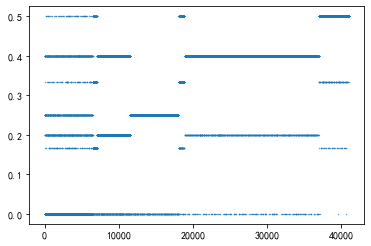

In [29]:
#plt.scatter(x=np.arange(len(pd_vision_f1)), y=pd_vision_f1, label='vision', s=0.1)
#plt.scatter(x=np.arange(len(pd_vision_f1)), y=pd_language_f1, label='language', s=0.1)
plt.scatter(x=np.arange(len(pd_vision_f1)), y=pd_multimodal_f1, label='multimodal', s=0.1)

(array([   80.,  1172.,  3063.,   286.,     0., 22678.,  5276.,  2288.,
          937.,  5274.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

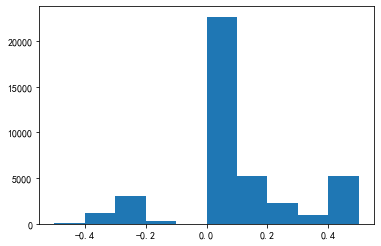

In [30]:
plt.hist(np.array(pd_vision_f1)-np.array(pd_language_f1))

## Compromised sample analysis

In [31]:
cp_sents = []
cp_cat_idxs = []
for idx in compromised:
    cp_sents.append(pd_sents[idx])
    cp_cat_idxs.append(gt_cat_idxs[idx])

In [32]:
cp_cat = {}
for cat_idxs in cp_cat_idxs:
    for idx in cat_idxs:
        cat = idx2cat[idx]
        cp_cat[cat] = cp_cat.get(cat, 0) + 1

# Compare Vision-Language difference

# Diff

In [33]:
vl_result_diff = vision_result - language_result

(array([  1.,   0.,   3.,   2.,   5.,   5.,   5.,  12.,  20., 231.]),
 array([-4.58635574e-02, -4.12870011e-02, -3.67104449e-02, -3.21338886e-02,
        -2.75573323e-02, -2.29807760e-02, -1.84042197e-02, -1.38276634e-02,
        -9.25110713e-03, -4.67455085e-03, -9.79945588e-05]),
 <BarContainer object of 10 artists>)

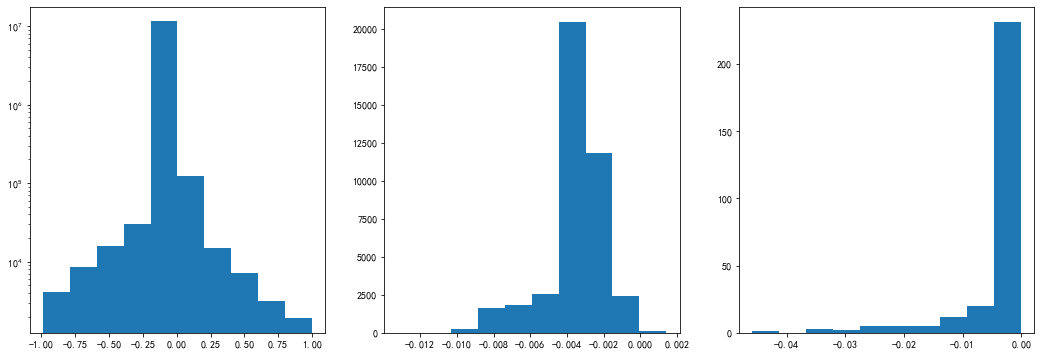

In [34]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(vl_result_diff.reshape(-1), log=True)
plt.subplot(1, 3, 2)
plt.hist(vl_result_diff.mean(axis=1)) # Mean sample diff
plt.subplot(1, 3, 3)
plt.hist(vl_result_diff.mean(axis=0)) # Mean label diff

# Diff of Compromised samples

(array([  1.,   1.,   1.,   3.,   2.,   3.,  10.,  13.,  21., 229.]),
 array([-0.04673  , -0.0420258, -0.0373216, -0.0326174, -0.0279132,
        -0.023209 , -0.0185048, -0.0138006, -0.0090964, -0.0043922,
         0.000312 ]),
 <BarContainer object of 10 artists>)

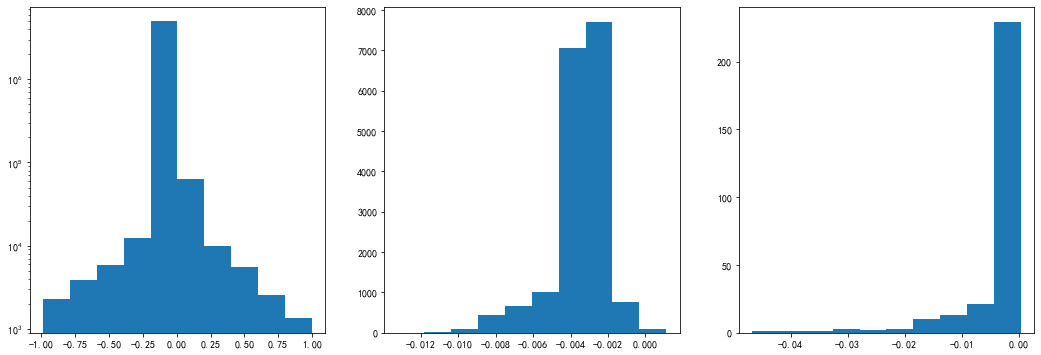

In [35]:
compromised_vl_result_diff = vl_result_diff[list(compromised)]
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(compromised_vl_result_diff.reshape(-1), log=True)
plt.subplot(1, 3, 2)
plt.hist(compromised_vl_result_diff.mean(axis=1)) # Mean sample diff
plt.subplot(1, 3, 3)
plt.hist(compromised_vl_result_diff.mean(axis=0)) # Mean label diff

## KL Divergence

In [36]:
vl_result_kl = kl_div(vision_result, language_result)

(array([224.,  23.,   9.,   8.,   5.,   6.,   3.,   1.,   3.,   2.]),
 array([9.00514926e-05, 7.69019685e-03, 1.52903422e-02, 2.28904876e-02,
        3.04906329e-02, 3.80907783e-02, 4.56909237e-02, 5.32910690e-02,
        6.08912144e-02, 6.84913597e-02, 7.60915051e-02]),
 <BarContainer object of 10 artists>)

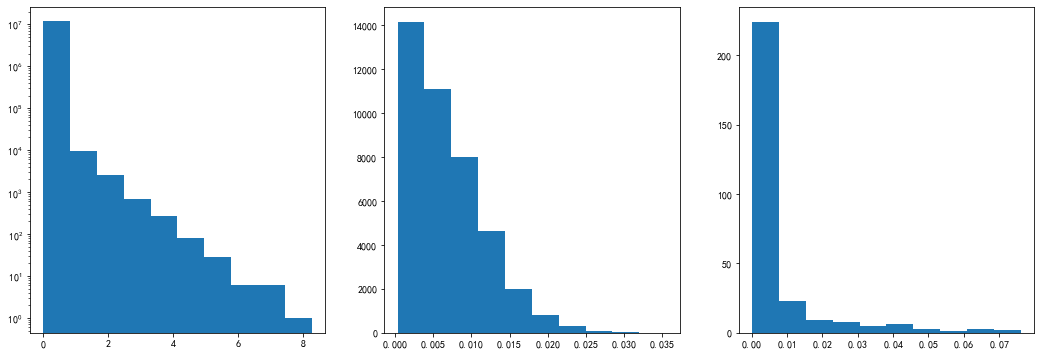

In [37]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(vl_result_kl.reshape(-1), log=True)
plt.subplot(1, 3, 2)
plt.hist(vl_result_kl.mean(axis=1)) # Mean sample kl
plt.subplot(1, 3, 3)
plt.hist(vl_result_kl.mean(axis=0)) # Mean label kl

## KL of Compromised samples

(array([225.,  25.,   7.,   6.,   6.,   5.,   3.,   3.,   2.,   2.]),
 array([1.08434918e-04, 1.11837475e-02, 2.22590600e-02, 3.33343726e-02,
        4.44096852e-02, 5.54849977e-02, 6.65603103e-02, 7.76356228e-02,
        8.87109354e-02, 9.97862480e-02, 1.10861561e-01]),
 <BarContainer object of 10 artists>)

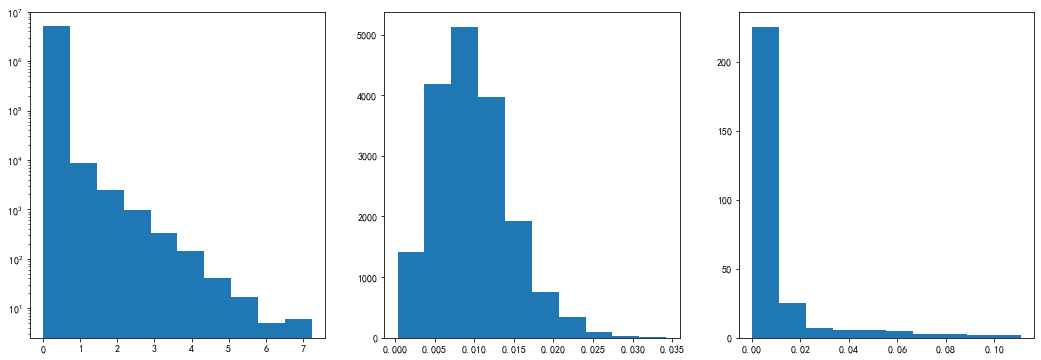

In [38]:
compromised_vl_result_kl = vl_result_kl[list(compromised)]
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(compromised_vl_result_kl.reshape(-1), log=True)
plt.subplot(1, 3, 2)
plt.hist(compromised_vl_result_kl.mean(axis=1)) # Mean sample kl
plt.subplot(1, 3, 3)
plt.hist(compromised_vl_result_kl.mean(axis=0)) # Mean label kl

## Multimodal superity

In [39]:
netative_label_cnt = (1 - gt_labels).sum()
positive_label_cnt = gt_labels.sum()

In [40]:
netative_label_cnt

11579940.0

In [41]:
positive_label_cnt

79396.0

In [42]:
negative_label = (multimodal_result > np.minimum(vision_result, language_result)) * (1 - gt_labels)
negative_label.sum() / netative_label_cnt

0.7939241481389369

In [43]:
positive_label = (multimodal_result < np.maximum(vision_result, language_result)) * gt_labels
positive_label.sum() / positive_label_cnt

0.1510655448637211

In [44]:
#stat = pd.DataFrame()
1/0
stat = {
    'pid': pd_pids,
    'caption': pd_sents,
    'categories': pd_labels,
    'vision_precision': pd_vision_precision,
    'vision_recall': pd_vision_recall,
    'vision_f1': pd_vision_f1,
    'language_precision': pd_language_precision,
    'language_recall': pd_language_recall,
    'language_f1': pd_language_f1,
    'multimodal_precision': pd_multimodal_precision,
    'multimodal_recall': pd_multimodal_recall,
    'multimodal_f1': pd_multimodal_f1
}
#stat.head()
#stat.to_csv('mm_fusion_comparison.csv', index=False)
with open('mm_fusion_comparison.csv', 'wb') as F:
    pickle.dump(stat, F)

ZeroDivisionError: division by zero